In [2]:
import numpy as np
import pandas as pd
import xpress as xp

In [3]:
# read-data
TransactionsInput = pd.read_excel("231013_Transactions_Input.xlsx")
FuardCases = pd.read_excel("231013_Fraud_Cases.xlsx")
CustomerBase = pd.read_excel("231013_Customer_Base.xlsx")

In [4]:
# TransactionsInput

In [5]:
FuardCases

,transaction_id,is_scam_transaction,fraud_type,case_id
0,187,1,AdvanceFee,5415844
1,247,1,Impersonation,4280670
2,818,1,Impersonation,6956462
3,891,1,Purchase,2702984
4,1142,1,Purchase,3493741
...,...,...,...,...
2476,313591,1,Impersonation,5711663
2477,314245,1,AdvanceFee,8032096
2478,314259,1,Purchase,1154155
2479,314411,1,AdvanceFee,4460117


In [6]:
# CustomerBase

# Data pre-process

In [7]:
# remove paid-in and cash withdraw transactions 
# https://saturncloud.io/blog/how-to-remove-rows-with-specific-values-in-pandas-dataframe/
# df = df.drop(df[df['product_name'] == 'Coca Cola'].index)
TransactionsInput_clean = TransactionsInput.drop(TransactionsInput[TransactionsInput['In_or_Out'] == 'paid_in'].index)
TransactionsInput_clean = TransactionsInput_clean.drop(TransactionsInput_clean[TransactionsInput_clean['category'] == 'Cash Withdraw'].index)

# merge customer prob with the input data
# https://www.geeksforgeeks.org/how-to-do-a-vlookup-in-python-using-pandaabss/
TransactionsInput_clean = pd.merge(TransactionsInput_clean, CustomerBase, on='customer_id', how='left')

# investigation time dataframe
Inestigation_time = pd.DataFrame(data={'priority':[1, 2, 3, 4], 'investigation time':[0.25, 0.5, 1, 2]}, index=([0, 1, 2, 3]))

# merge inverstigation time with the input data
TransactionsInput_clean = pd.merge(TransactionsInput_clean, Inestigation_time, on='priority', how='left')
TransactionsInput_clean

# merge fraud cases with transaction input data
TransactionInput_clean_fraud = pd.merge(TransactionsInput_clean,FuardCases,on='transaction_id', how='left')
TransactionInput_clean_fraud


,transaction_id,description,Amount,category,date,month,customer_id,type,In_or_Out,bank_to,bank_from,transac_prob,description_prob,priority,home_bank,customer_prob,investigation time,is_scam_transaction,fraud_type,case_id
0,2,Online Retailer - Electronics Purchase,199.99,Online Shopping,2023-10-01,October,10298,spending,paid_out,bank_A,bank_E,0.78,0.25,3,bank_E,0.49,1.00,NaN,NaN,NaN
1,3,Utilities Payment - Internet Service,60.00,Utilities,2023-10-01,October,10298,spending,paid_out,bank_C,bank_E,0.30,0.22,1,bank_E,0.49,0.25,NaN,NaN,NaN
2,4,Rent Payment,1500.00,Housing,2023-10-01,October,14507,spending,paid_out,bank_D,bank_E,0.57,0.53,3,bank_E,0.35,1.00,NaN,NaN,NaN
3,6,Online Retailer - Electronics Purchase,299.99,Online Shopping,2023-10-01,October,14507,spending,paid_out,bank_E,bank_E,0.75,0.65,3,bank_E,0.35,1.00,NaN,NaN,NaN
4,7,Asos - Online Fashion Shopping,55.00,Shopping,2023-10-01,October,14507,spending,paid_out,bank_B,bank_E,0.37,0.31,1,bank_E,0.35,0.25,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295727,315178,Grocery Shopping - Super Value Mart,55.25,Groceries,2024-07-31,July,15026,spending,paid_out,bank_C,bank_B,0.42,0.17,1,bank_B,0.52,0.25,NaN,NaN,NaN
295728,315179,JCPenney - Discount Fashion,40.00,Shopping,2024-07-31,July,11908,spending,paid_out,bank_D,bank_A,0.36,0.36,1,bank_A,0.32,0.25,NaN,NaN,NaN
295729,315180,Gas Station - Fuel Purchase,40.45,Transportation,2024-07-31,July,10291,spending,paid_out,bank_D,bank_D,0.28,0.64,1,bank_D,0.35,0.25,NaN,NaN,NaN
295730,315181,ATM Withdrawal - PQR Bank ATM,80.00,Cash Withdrawal,2024-07-31,July,18543,spending,paid_out,NaN,bank_A,0.24,0.23,2,bank_A,0.20,0.50,NaN,NaN,NaN


In [8]:
# find seasonal patten

Fuard_time = pd.merge(TransactionsInput,FuardCases, on="transaction_id")[["date","month"]]
Fuard_time['month'] = Fuard_time.apply(lambda row: row['month'] + str(row['date'].year), axis=1)
unique_date, counts_date = np.unique(Fuard_time[['date']], return_counts=True)
unique_month, counts_month = np.unique(Fuard_time[['month']], return_counts=True)
frequency_date = dict(zip(unique_date, counts_date))
frequency_month = dict(zip(unique_month, counts_month))  
print(frequency_date)
print(frequency_month)

{numpy.datetime64('2023-10-01T00:00:00.000000000'): 18, numpy.datetime64('2023-10-02T00:00:00.000000000'): 6, numpy.datetime64('2023-10-03T00:00:00.000000000'): 20, numpy.datetime64('2023-10-04T00:00:00.000000000'): 7, numpy.datetime64('2023-10-05T00:00:00.000000000'): 8, numpy.datetime64('2023-10-06T00:00:00.000000000'): 8, numpy.datetime64('2023-10-07T00:00:00.000000000'): 4, numpy.datetime64('2023-10-08T00:00:00.000000000'): 8, numpy.datetime64('2023-10-09T00:00:00.000000000'): 9, numpy.datetime64('2023-10-10T00:00:00.000000000'): 6, numpy.datetime64('2023-10-11T00:00:00.000000000'): 5, numpy.datetime64('2023-10-12T00:00:00.000000000'): 13, numpy.datetime64('2023-10-13T00:00:00.000000000'): 7, numpy.datetime64('2023-10-14T00:00:00.000000000'): 8, numpy.datetime64('2023-10-15T00:00:00.000000000'): 9, numpy.datetime64('2023-10-16T00:00:00.000000000'): 6, numpy.datetime64('2023-10-17T00:00:00.000000000'): 6, numpy.datetime64('2023-10-18T00:00:00.000000000'): 8, numpy.datetime64('2023-1

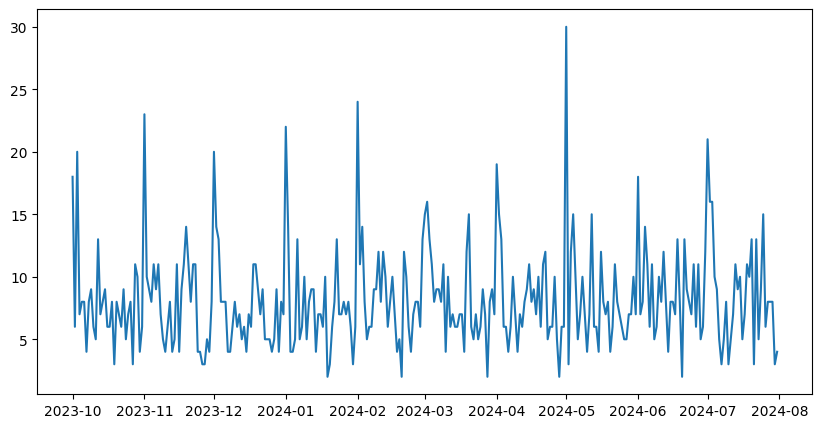

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(unique_date,counts_date)

In [10]:
# just use for testing
# customer_num = 10

In [11]:
# TransactionsInput_clean_test = TransactionsInput_clean[0:10]
# TransactionsInput_clean_test

In [12]:
# Create a problem called transaction
# xp.init('D:/xpressmp/bin/xpauth.xpr')
prob = xp.problem(name='transaction') 

# define the daily model
def daily_model(TransactionsInput, ex_lim, C4_cont):
    '''
    with input the data from the day before yesterday and ex_lim 
    to find the optimal solution   
    '''
    # data

    number_of_transactions = len(TransactionsInput["transaction_id"])
    number_of_priorities = 4
    number_of_banks = 5
    transactions = range(number_of_transactions)
    priorities = range(number_of_priorities)
    banks = range(number_of_banks)

    # transaction values
    value = np.array(TransactionsInput['Amount'])

    # transaction and customer probabilities
    TP = np.array(TransactionsInput['transac_prob'])
    CP = np.array(TransactionsInput['customer_prob'])

    # investigation team size
    inve_team_size = np.array([8, 12, 10, 10, 10])

    # bank names
    bank_names = np.array(['bank_A', 'bank_B', 'bank_C', 'bank_D', 'bank_E'])

    # bank_to/from binary array
    bank_to = np.array([1 if TransactionsInput.iloc[i, 9] == bank_names[b] else 0 
                        for b in banks for i in transactions]).reshape(number_of_banks, number_of_transactions)
    bank_from = np.array([1 if TransactionsInput.iloc[i, 10] == bank_names[b] else 0 
                        for b in banks for i in transactions]).reshape(number_of_banks, number_of_transactions)

    # constrain array for decision variable
    Array1 = np.add(bank_to, bank_from)

    for i in transactions:
        if TransactionsInput.loc[i].at['priority'] == 4:
            Array1[:, i] = 0
    Array1 = np.add(bank_to, bank_from)

    Array2 = np.add(bank_to, bank_from)

    for i in transactions:
        if TransactionsInput.loc[i].at['priority'] != 4:
            Array2[:, i] = 0

    # investigation time for each transaction
    inve_time = np.array(TransactionsInput['investigation time'])

    # external investigator cost for each priority
    ex_inve_cost = np.array(TransactionsInput['investigation time'])

    # parameters
    beta_tran = 0.5
    beta_cust = 0.5

    # use ndarry to shape decision variables

    X = np.array([xp.var(vartype=xp.binary, name='X_{0}_{1}'.format(b+1, i+1)) 
                        for b in banks for i in transactions], dtype=xp.npvar).reshape(number_of_banks, number_of_transactions)
    X4 = np.array([xp.var(vartype=xp.binary, name='X4_{0}_{1}'.format(b+1, i+1)) 
                        for b in banks for i in transactions], dtype=xp.npvar).reshape(number_of_banks, number_of_transactions)
    Z = np.array([xp.var(vartype=xp.binary, name='Z_{0}_{1}'.format(i+1, b+1)) 
                        for b in banks for i in transactions], dtype=xp.npvar).reshape(number_of_banks, number_of_transactions)
    Z4 = np.array([xp.var(vartype=xp.binary, name='Z4_{0}_{1}'.format(i+1, b+1)) 
                        for b in banks for i in transactions], dtype=xp.npvar).reshape(number_of_banks, number_of_transactions)
    # Ex_hire = np.array([xp.var(name='Ex_hire_{0}_{1}'.format(b+1, p+1)) 
    #                     for b in banks for p in priorities], dtype=xp.npvar).reshape(number_of_banks, number_of_priorities)
    C = np.array([xp.var(vartype=xp.integer, name='C_{0}'.format(b+1))
                        for b in banks], dtype=xp.npvar).reshape(number_of_banks, )
    C4 = np.array([xp.var(vartype=xp.integer, name='C4_{0}'.format(b+1))
                        for b in banks], dtype=xp.npvar).reshape(number_of_banks, )

    prob.addVariable(X, X4, Z, Z4, C, C4)

    # constrains

    # each transaction can be investigated by at most one bank
    prob.addConstraint(xp.Sum(X[n, i] + X4[n, i] + Z[n, i] + Z4[n, i] for n in banks) <= 1 for i in transactions)

    # for each bank, internal investigation time should less than the people contributed
    prob.addConstraint(xp.Sum(inve_time[i]*X[n, i] for i in transactions) <= C[n] for n in banks)
    prob.addConstraint(xp.Sum(inve_time[i]*X4[n, i] for i in transactions) <= C4[n] for n in banks)

    # for each bank, team size should larger than the people contributed
    prob.addConstraint((C[n] + C4[n] + C4_cont[n]) <= inve_team_size[n] for n in banks)

    # for decision variables of transactions with priority 123, columns of transactions with priority 4 should be 0;
    # for decision variables of transactions with priority 4, columns of transactions with priority 123 should be 0;
    prob.addConstraint(Z[n, i] <= Array1[n, i] for i in transactions for n in banks)
    prob.addConstraint(X[n, i] <= Array1[n, i] for i in transactions for n in banks)
    prob.addConstraint(Z4[n, i] <= Array2[n, i] for i in transactions for n in banks)
    prob.addConstraint(X4[n, i] <= Array2[n, i] for i in transactions for n in banks)

    # in order to limit the external hiring cost 
    prob.addConstraint(xp.Sum(Z[n, i] + Z4[n, i] for i in transactions for n in banks) <= ex_lim)

    # add objective function
    # expect value on investigation cost
    prob.setObjective(xp.Sum(value[i]*(beta_tran*TP[i] + beta_cust*CP[i])*(1 - Z[n, i] - X[n, i] - Z4[n, i] - X4[n, i])
                    + (Z4[n, i] + Z[n, i])*ex_inve_cost[i] for i in transactions for n in banks), sense=xp.minimize)

    # solve problem
    prob.write("problem","lp")
    prob.solve()

    # display results
    X_optimal = pd.DataFrame(data = prob.getSolution(X), index = bank_names, columns = transactions)
    X4_optimal = pd.DataFrame(data = prob.getSolution(X4), index = bank_names, columns = transactions)
    Z_optimal = pd.DataFrame(data = prob.getSolution(Z), index = bank_names, columns = transactions)
    Z4_optimal = pd.DataFrame(data = prob.getSolution(Z4), index = bank_names, columns = transactions)
    C_optimal = pd.DataFrame(data = prob.getSolution(C), index = bank_names, columns = ['C'])
    C4_optimal = pd.DataFrame(data = prob.getSolution(C4), index = bank_names, columns = ['C4'])

    return X_optimal, X4_optimal, Z_optimal, Z4_optimal
    # display(X_optimal)
    # display(X4_optimal)
    # display(Z_optimal)
    # display(Z4_optimal)
    # display(C_optimal)
    # display(C4_optimal)

Using the Community license in this session. If you have a full Xpress license, pass the full path to your license file to xpress.init(). If you want to use the FICO Community license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/home/codespace/.python/current/lib/python3.10/site-packages/xpress/license/community-xpauth.xpr')


In [13]:
# define the optimal model
def optimal_model(TransactionsFraud):
    '''
    in case we know the fraud cases, returns the optimal value
    '''

    # use ndarry to shape decision variables
    number_of_transactions = len(TransactionsFraud["transaction_id"])
    number_of_priorities = 4
    number_of_banks = 5
    transactions = range(number_of_transactions)
    priorities = range(number_of_priorities)
    banks = range(number_of_banks)

    X_om = np.array([xp.var(vartype=xp.binary, name='X_om_{0}_{1}'.format(b+1, i+1)) 
                        for b in banks for i in transactions], dtype=xp.npvar).reshape(number_of_banks, number_of_transactions)
    X4_om = np.array([xp.var(vartype=xp.binary, name='X4_om_{0}_{1}'.format(b+1, i+1)) 
                        for b in banks for i in transactions], dtype=xp.npvar).reshape(number_of_banks, number_of_transactions)
    Z_om = np.array([xp.var(vartype=xp.binary, name='Z_om_{0}_{1}'.format(i+1, b+1)) 
                        for b in banks for i in transactions], dtype=xp.npvar).reshape(number_of_banks, number_of_transactions)
    Z4_om = np.array([xp.var(vartype=xp.binary, name='Z4_om_{0}_{1}'.format(i+1, b+1)) 
                        for b in banks for i in transactions], dtype=xp.npvar).reshape(number_of_banks, number_of_transactions)
    # Ex_hire = np.array([xp.var(name='Ex_hire_{0}_{1}'.format(b+1, p+1)) 
    #                     for b in banks for p in priorities], dtype=xp.npvar).reshape(number_of_banks, number_of_priorities)
    C_om = np.array([xp.var(vartype=xp.integer, name='C_{0}'.format(b+1))
                        for b in banks], dtype=xp.npvar).reshape(number_of_banks, )
    C4_om = np.array([xp.var(vartype=xp.integer, name='C4_om_{0}'.format(b+1))
                        for b in banks], dtype=xp.npvar).reshape(number_of_banks, )

    prob.addVariable(X_om, X4_om, Z_om, Z4_om, C_om, C4_om)

    # data

    # transaction values
    value = np.array(TransactionsFraud['Amount'])

    # fraud infomations
    f = np.array(TransactionsFraud['is_scam_transaction'])

    # investigation team size
    inve_team_size = np.array([8, 12, 10, 10, 10])

    # bank names
    bank_names = np.array(['bank_A', 'bank_B', 'bank_C', 'bank_D', 'bank_E'])

    # bank_to/from binary array
    bank_to = np.array([1 if TransactionsFraud.iloc[i, 9] == bank_names[b] else 0 
                        for b in banks for i in transactions]).reshape(number_of_banks, number_of_transactions)
    bank_from = np.array([1 if TransactionsFraud.iloc[i, 10] == bank_names[b] else 0 
                        for b in banks for i in transactions]).reshape(number_of_banks, number_of_transactions)

    # constrain array for decision variable
    Array1 = np.add(bank_to, bank_from)

    for i in transactions:
        if TransactionsFraud.loc[i].at['priority'] == 4:
            Array1[:, i] = 0
    Array1 = np.add(bank_to, bank_from)

    Array2 = np.add(bank_to, bank_from)

    for i in transactions:
        if TransactionsFraud.loc[i].at['priority'] != 4:
            Array2[:, i] = 0

    # investigation time for each transaction
    inve_time = np.array(TransactionsFraud['investigation time'])

    # external investigator cost for each priority
    ex_inve_cost = np.array(TransactionsFraud['investigation time'])

    # create an array to store the number of internal people continuing on priority 4
    C4_om_cont = np.array([0]*number_of_banks)

    # constrains

    # each transaction can be investigated by at most one bank
    prob.addConstraint(xp.Sum(X_om[n, i] + X4_om[n, i] + Z_om[n, i] + Z4_om[n, i] for n in banks) <= 1 for i in transactions)

    # for each bank, internal investigation time should less than the people contributed
    prob.addConstraint(xp.Sum(inve_time[i]*X_om[n, i] for i in transactions) <= C_om[n] for n in banks)
    prob.addConstraint(xp.Sum(inve_time[i]*X4_om[n, i] for i in transactions) <= C4_om[n] for n in banks)

    # for each bank, team size should larger than the people contributed
    prob.addConstraint((C_om[n] + C4_om[n] + C4_om_cont[n]) <= inve_team_size[n] for n in banks)

    # for decision variables of transactions with priority 123, columns of transactions with priority 4 should be 0;
    # for decision variables of transactions with priority 4, columns of transactions with priority 123 should be 0;
    prob.addConstraint(Z_om[n, i] <= Array1[n, i] for i in transactions for n in banks)
    prob.addConstraint(X_om[n, i] <= Array1[n, i] for i in transactions for n in banks)
    prob.addConstraint(Z4_om[n, i] <= Array2[n, i] for i in transactions for n in banks)
    prob.addConstraint(X4_om[n, i] <= Array2[n, i] for i in transactions for n in banks)

    # add objective function
    # expect value on investigation cost
    prob.setObjective(xp.Sum(value[i]*f[i]*(1 - Z_om[n, i] - X_om[n, i] - Z4_om[n, i] - X4_om[n, i])
                    + (Z4_om[n, i] + Z_om[n, i])*ex_inve_cost[i] for i in transactions for n in banks), sense=xp.minimize)

    # solve problem
    prob.write("problem","lp")
    prob.solve()

    # display results
    X_om_optimal = pd.DataFrame(data = prob.getSolution(X_om), index = bank_names, columns = transactions)
    X4_om_optimal = pd.DataFrame(data = prob.getSolution(X4_om), index = bank_names, columns = transactions)
    Z_om_optimal = pd.DataFrame(data = prob.getSolution(Z_om), index = bank_names, columns = transactions)
    Z4_om_optimal = pd.DataFrame(data = prob.getSolution(Z4_om), index = bank_names, columns = transactions)
    C_om_optimal = pd.DataFrame(data = prob.getSolution(C_om), index = bank_names, columns = ['C_om'])
    C4_om_optimal = pd.DataFrame(data = prob.getSolution(C4_om), index = bank_names, columns = ['C4_om'])

    return X_om_optimal, X4_om_optimal, Z_om_optimal, Z4_om_optimal
    # display(X_optimal)
    # display(X4_om_optimal)
    # display(Z_optimal)
    # display(Z4_om_optimal)
    # display(C_optimal)
    # display(C4_om_optimal)

In [14]:
# define parameter model
def para_model(X, X4, Z, Z4, TransactionsFraud):
    '''
    returns the optimal value of the optimal model
    '''
    # use ndarry to shape decision variables
    number_of_transactions = len(TransactionsFraud["transaction_id"])
    number_of_priorities = 4
    number_of_banks = 5
    transactions = range(number_of_transactions)
    priorities = range(number_of_priorities)
    banks = range(number_of_banks)

    # data

    # transaction values
    value = np.array(TransactionsFraud['Amount'])

    # fraud infomations
    f = np.array(TransactionsFraud['is_scam_transaction'])

    # external investigator cost for each priority
    ex_inve_cost = np.array(TransactionsFraud['investigation time'])

    ObjVal = xp.Sum(value[i]*f[i]*(1 - Z[n, i] - X[n, i] - Z4[n, i] - X4[n, i])
                    + (Z4[n, i] + Z[n, i])*ex_inve_cost[i] for i in transactions for n in banks)
    
    return ObjVal

In [1]:
# introduce data at each round
dates = np.array(TransactionsInput['date'])
days = np.unique(dates)
C4_cont = [0]*5

# loop over the days
for d in days[0:1]:

    ex_lim_dic = {}
    TransactionsInput_daily = TransactionsInput_clean.loc[TransactionsInput_clean['date'] == d]
    TransactionsFraud_daily = TransactionInput_clean_fraud.loc[TransactionInput_clean_fraud['date'] == d]

    for ex_lim in range(len(TransactionsInput_daily[0: 10])):

        X_om_optimal, X4_om_optimal, Z_om_optimal, Z4_om_optimal = daily_model(TransactionsInput_daily[0: 10], ex_lim, C4_cont)
        X_optimal, X4_optimal, Z_optimal, Z4_optimal = optimal_model(TransactionsFraud_daily[0: 10])

        ex_lim_dic[ex_lim] = para_model(X_om_optimal, X4_om_optimal, Z_om_optimal, Z4_om_optimal, TransactionsFraud_daily[0: 10]) 
        - para_model(X_optimal, X4_optimal, Z_optimal, Z4_optimal, TransactionsFraud_daily[0: 10])
    print(ex_lim_dic)
# create an array to store the number of internal investigators continuing on priority 4
C4_cont = np.array([0]*5)

NameError: name 'np' is not defined